# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
!pip install feature-engine

In [2]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

#correlation matrix
import seaborn as sns

#RareLabelEncoder
from feature_engine.encoding import RareLabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [4]:
# Mostrar todas las columnas
pd.set_option('display.max_columns', None)

In [5]:
websites = pd.read_csv('/content/drive/MyDrive/1. IRONHACK/BBDD/Copia de website.csv')
websites.head()

#Type: nos dice si es benigna o maligna

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [6]:
# Your code here
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1781 non-null   object 
 4   SERVER                     1780 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1781 non-null   object 
 7   WHOIS_STATEPRO             1781 non-null   object 
 8   WHOIS_REGDATE              1781 non-null   object 
 9   WHOIS_UPDATED_DATE         1781 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

In [7]:
# Obtener cantidad y porcentaje de valores nulos
nulls = websites.isnull().sum().sort_values(ascending = False).reset_index()
nulls.columns = ['features','missing_num']
nulls['missing_percentage'] = nulls['missing_num']/websites.shape[0]*100
nulls['missing_percentage'] = nulls['missing_percentage'].round(1)

#Contar valores únicos
for feature in nulls['features']:
    nulls.loc[(nulls['features'] == feature), 'unique_values'] = len(websites[feature].unique())
nulls['unique_values'] = nulls['unique_values'].astype(int)

# Columnas con nulos
nulls_relevant = nulls.iloc[2:8, :]

nulls

,features,missing_num,missing_percentage,unique_values
0,CONTENT_LENGTH,812,45.6,638
1,SERVER,1,0.1,240
2,DNS_QUERY_TIMES,1,0.1,11
3,Type,0,0.0,2
4,WHOIS_UPDATED_DATE,0,0.0,594
5,URL_LENGTH,0,0.0,142
6,NUMBER_SPECIAL_CHARACTERS,0,0.0,31
7,CHARSET,0,0.0,9
8,WHOIS_COUNTRY,0,0.0,49
9,WHOIS_STATEPRO,0,0.0,182


In [8]:
#Remove CONTENT_LENGTH column as it has 45.6% of null values 
#Remove rows with NaN values
websites = websites.drop('CONTENT_LENGTH', axis = 1).dropna()
websites.isnull().sum()

URL                          0
URL_LENGTH                   0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_STATEPRO               0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_PACKETS           0
REMOTE_APP_PACKETS           0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
APP_PACKETS                  0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

In [9]:
websites.Type.value_counts()
#vamos con el supuesto de que 0 es NO maliciosa (benigna) y 1 es maliciosa 

0    1563
1     216
Name: Type, dtype: int64

#### Next, evaluate if the columns in this dataset are strongly correlated.

In the Mushroom supervised learning lab we did recently, we mentioned we are concerned if our dataset has strongly correlated columns because if it is the case we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [10]:
# Your code here
corr_matrix = websites.corr()
corr_matrix.head()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,0.918098,-0.038159,-0.039696,-0.046174,-0.026416,-0.041967,-0.033481,-0.014628,-0.026652,-0.041967,-0.068453,0.162641
NUMBER_SPECIAL_CHARACTERS,0.918098,1.000000,-0.037323,-0.042554,-0.046961,-0.023896,-0.039939,-0.030467,-0.014276,-0.024079,-0.039939,-0.050067,0.281150
TCP_CONVERSATION_EXCHANGE,-0.038159,-0.037323,1.000000,0.555180,0.331057,0.457324,0.997798,0.990871,0.865585,0.458705,0.997798,0.349877,-0.040276
DIST_REMOTE_TCP_PORT,-0.039696,-0.042554,0.555180,1.000000,0.210198,0.780243,0.558601,0.591173,0.313333,0.781216,0.558601,0.259919,-0.082999
REMOTE_IPS,-0.046174,-0.046961,0.331057,0.210198,1.000000,0.023124,0.361087,0.304712,0.171660,0.025322,0.361087,0.548413,-0.078801


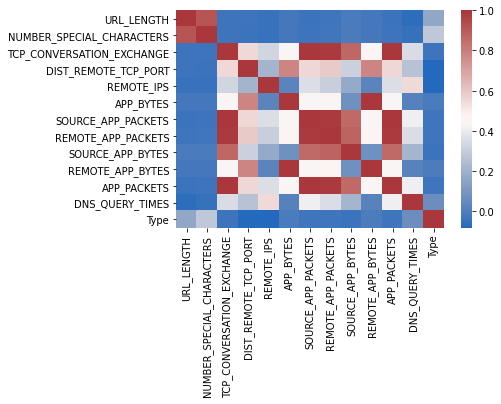

In [11]:
sns.heatmap(corr_matrix, cmap='vlag');

In [12]:
# Alta correlación positiva:
#Remote_app_packets & Source_App_Packets
#Number_special_characters & Url_Lenght
#TCP_Conversation_exchange & Source_App_Packets
#TCP_Conversation_exchange & Remote_App_Packets

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

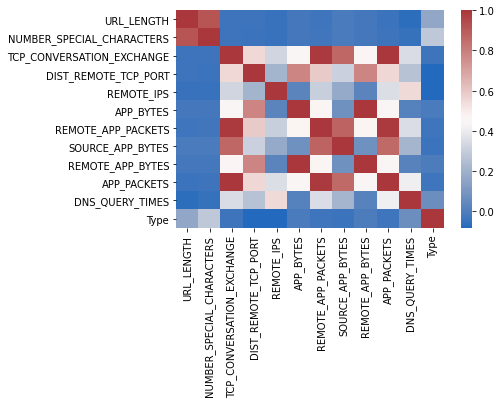

In [13]:
#Primer columna a quitar: Source App Packets
websites_2 = websites.drop('SOURCE_APP_PACKETS', axis = 1)
corr_matrix2 = websites_2.corr()
sns.heatmap(corr_matrix2, cmap='vlag');

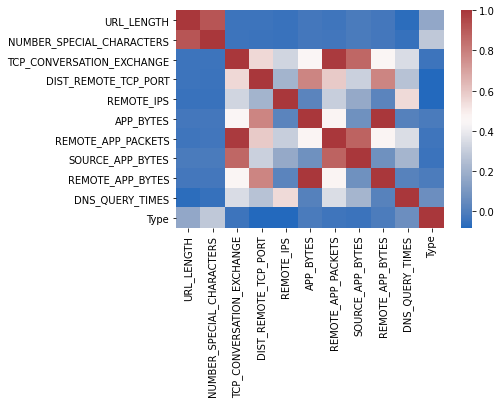

In [14]:
#Segunda columna a quitar: APP_PACKETS
websites_3 = websites_2.drop('APP_PACKETS', axis = 1)
corr_matrix3 = websites_3.corr()
sns.heatmap(corr_matrix3, cmap='vlag');

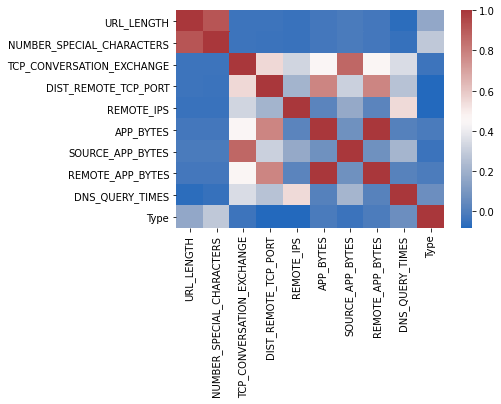

In [15]:
#Tercer columna a quitar: APP_PACKETS
websites_4 = websites_3.drop('REMOTE_APP_PACKETS', axis = 1)
corr_matrix4 = websites_4.corr()
sns.heatmap(corr_matrix4, cmap='vlag');

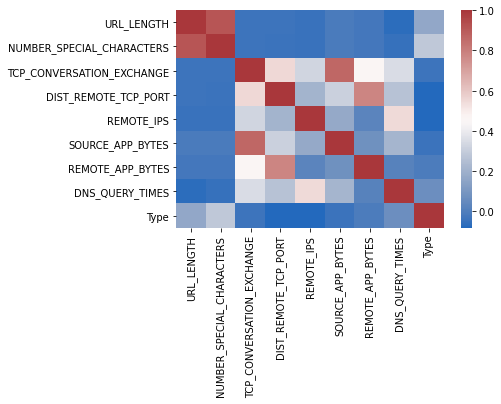

In [16]:
#Cuarta columna a quitar: APP_BYTES
websites_5 = websites_4.drop('APP_BYTES', axis = 1)
corr_matrix5 = websites_5.corr()
sns.heatmap(corr_matrix5, cmap='vlag');

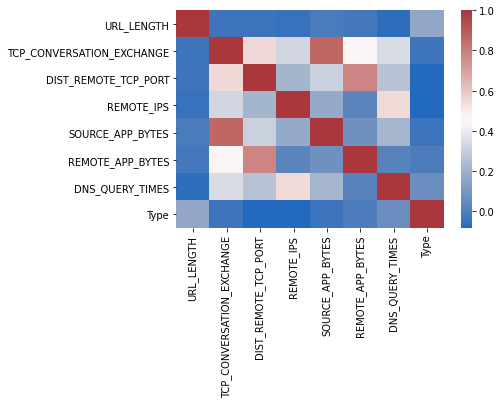

In [17]:
#quinta columna a quitar: NUMBER_SPECIAL_CHARACTERS
websites_6 = websites_5.drop('NUMBER_SPECIAL_CHARACTERS', axis = 1)
corr_matrix6 = websites_6.corr()
sns.heatmap(corr_matrix6, cmap='vlag');
#listo!

In [18]:
corr_matrix6

,URL_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
URL_LENGTH,1.000000,-0.038159,-0.039696,-0.046174,-0.014628,-0.026652,-0.068453,0.162641
TCP_CONVERSATION_EXCHANGE,-0.038159,1.000000,0.555180,0.331057,0.865585,0.458705,0.349877,-0.040276
DIST_REMOTE_TCP_PORT,-0.039696,0.555180,1.000000,0.210198,0.313333,0.781216,0.259919,-0.082999
REMOTE_IPS,-0.046174,0.331057,0.210198,1.000000,0.171660,0.025322,0.548413,-0.078801
SOURCE_APP_BYTES,-0.014628,0.865585,0.313333,0.171660,1.000000,0.075319,0.215227,-0.043949
REMOTE_APP_BYTES,-0.026652,0.458705,0.781216,0.025322,0.075319,1.000000,0.016201,-0.011024
DNS_QUERY_TIMES,-0.068453,0.349877,0.259919,0.548413,0.215227,0.016201,1.000000,0.068606
Type,0.162641,-0.040276,-0.082999,-0.078801,-0.043949,-0.011024,0.068606,1.000000


# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [19]:
# Your code here
websites_6 = websites_6.replace(to_replace="None", value=np.nan)
websites_6.isnull().sum()

URL                            0
URL_LENGTH                     0
CHARSET                        7
SERVER                       175
WHOIS_COUNTRY                306
WHOIS_STATEPRO               362
WHOIS_REGDATE                127
WHOIS_UPDATED_DATE           139
TCP_CONVERSATION_EXCHANGE      0
DIST_REMOTE_TCP_PORT           0
REMOTE_IPS                     0
SOURCE_APP_BYTES               0
REMOTE_APP_BYTES               0
DNS_QUERY_TIMES                0
Type                           0
dtype: int64

If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [20]:
# Your code here
# Obtener cantidad y porcentaje de valores nulos
nulls = websites_6.isnull().sum().sort_values(ascending = False).reset_index()
nulls.columns = ['features','missing_num']
nulls['missing_percentage'] = nulls['missing_num']/websites_6.shape[0]*100
nulls['missing_percentage'] = nulls['missing_percentage'].round(1)

#Contar valores únicos
for feature in nulls['features']:
    nulls.loc[(nulls['features'] == feature), 'unique_values'] = len(websites_6[feature].unique())
nulls['unique_values'] = nulls['unique_values'].astype(int)

# Columnas con nulos
nulls_relevant = nulls.iloc[2:8, :]

nulls

,features,missing_num,missing_percentage,unique_values
0,WHOIS_STATEPRO,362,20.3,181
1,WHOIS_COUNTRY,306,17.2,49
2,SERVER,175,9.8,239
3,WHOIS_UPDATED_DATE,139,7.8,593
4,WHOIS_REGDATE,127,7.1,889
5,CHARSET,7,0.4,9
6,Type,0,0.0,2
7,DNS_QUERY_TIMES,0,0.0,10
8,REMOTE_APP_BYTES,0,0.0,822
9,SOURCE_APP_BYTES,0,0.0,885


#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [23]:
#CONTENT_LENGHT tiene más del 20% de nulos, vamos a eliminarla
websites_clean = websites_6.drop('WHOIS_STATEPRO', axis=1)
websites_clean.head()

,URL,URL_LENGTH,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
0,M0_109,16,iso-8859-1,nginx,NaN,10/10/2015 18:21,NaN,7,0,2,1153,832,2.0,1
1,B0_2314,16,UTF-8,Apache/2.4.10,NaN,NaN,NaN,17,7,4,1265,1230,0.0,0
2,B0_911,16,us-ascii,Microsoft-HTTPAPI/2.0,NaN,NaN,NaN,0,0,0,0,0,0.0,0
3,B0_113,17,ISO-8859-1,nginx,US,7/10/1997 4:00,12/09/2013 0:45,31,22,3,18784,4380,8.0,0
4,B0_403,17,UTF-8,NaN,US,12/05/1996 0:00,11/04/2017 0:00,57,2,5,129889,4586,4.0,0


In [24]:
# Your code here
# Obtener cantidad y porcentaje de valores nulos
nulls = websites_clean.isnull().sum().sort_values(ascending = False).reset_index()
nulls.columns = ['features','missing_num']
nulls['missing_percentage'] = nulls['missing_num']/websites_clean.shape[0]*100
nulls['missing_percentage'] = nulls['missing_percentage'].round(1)

#Contar valores únicos
for feature in nulls['features']:
    nulls.loc[(nulls['features'] == feature), 'unique_values'] = len(websites_clean[feature].unique())
nulls['unique_values'] = nulls['unique_values'].astype(int)

# Columnas con nulos
nulls_relevant = nulls.iloc[2:8, :]

nulls

,features,missing_num,missing_percentage,unique_values
0,WHOIS_COUNTRY,306,17.2,49
1,SERVER,175,9.8,239
2,WHOIS_UPDATED_DATE,139,7.8,593
3,WHOIS_REGDATE,127,7.1,889
4,CHARSET,7,0.4,9
5,Type,0,0.0,2
6,DNS_QUERY_TIMES,0,0.0,10
7,REMOTE_APP_BYTES,0,0.0,822
8,SOURCE_APP_BYTES,0,0.0,885
9,REMOTE_IPS,0,0.0,18


In [25]:
#dropeo las filas de los features que aun tienen nulos:
websites_clean = websites_clean.drop(websites_clean[websites_clean['WHOIS_COUNTRY'].isnull()].index, axis = 0)
websites_clean = websites_clean.drop(websites_clean[websites_clean['SERVER'].isnull()].index, axis = 0)
websites_clean = websites_clean.drop(websites_clean[websites_clean['WHOIS_UPDATED_DATE'].isnull()].index, axis = 0)
websites_clean = websites_clean.drop(websites_clean[websites_clean['WHOIS_REGDATE'].isnull()].index, axis = 0)
websites_clean = websites_clean.drop(websites_clean[websites_clean['CHARSET'].isnull()].index, axis = 0)
websites_clean = websites_clean.drop(websites_clean[websites_clean['DNS_QUERY_TIMES'].isnull()].index, axis = 0)

In [26]:
websites_clean.isnull().sum()

URL                          0
URL_LENGTH                   0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
SOURCE_APP_BYTES             0
REMOTE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [27]:
# Your code here
websites_clean.WHOIS_COUNTRY.unique()

array(['US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN', 'LU', 'GB',
       "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE', 'SI', 'IL',
       'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES',
       'us', 'KR', 'HK', 'UA', 'CH', 'BS', 'PK', 'IT', 'Cyprus', 'BY',
       'AE', 'IE', 'UY', 'KG'], dtype=object)

In [28]:
websites_clean['WHOIS_COUNTRY'] = websites_clean['WHOIS_COUNTRY'].replace({'United Kingdom':'GB','Cyprus':'CY', "[u'GB'; u'UK']":'GB', 'us':'US', 'se':'SE', 'ru':'RU'})

In [29]:
websites_clean.WHOIS_COUNTRY.unique()

array(['US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU', 'GB',
       'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'KY', 'AT', 'CZ', 'PH',
       'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'KR', 'HK', 'UA', 'CH', 'BS',
       'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'], dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [30]:
# Your code here
websites_clean['WHOIS_COUNTRY'].value_counts().head(10)

US    960
CA     75
ES     63
AU     34
GB     22
PA     21
JP     11
UK     10
CN      9
CZ      9
Name: WHOIS_COUNTRY, dtype: int64

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [31]:
# Your code here
rare_encoder = RareLabelEncoder(tol = 0, n_categories = 10, variables = 'WHOIS_COUNTRY', max_n_categories = 10, replace_with = 'Other')

In [32]:
rare_encoder.fit(websites_clean)

RareLabelEncoder(max_n_categories=10, n_categories=10, replace_with='Other',
                 tol=0, variables=['WHOIS_COUNTRY'])

In [33]:
websites_clean = rare_encoder.transform(websites_clean)
websites_clean.head(2)

,URL,URL_LENGTH,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type
3,B0_113,17,ISO-8859-1,nginx,US,7/10/1997 4:00,12/09/2013 0:45,31,22,3,18784,4380,8.0,0
5,B0_2064,18,UTF-8,nginx,Other,3/08/2016 14:30,3/10/2016 3:45,11,6,9,838,894,0.0,0


In [35]:
websites_clean.WHOIS_COUNTRY.unique()

array(['US', 'Other', 'UK', 'AU', 'CA', 'PA', 'GB', 'JP', 'CN', 'CZ',
       'ES'], dtype=object)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [37]:
# Your code here
websites_clean = websites_clean.drop(['WHOIS_REGDATE', 'WHOIS_UPDATED_DATE'], axis = 1)
websites_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 3 to 1780
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1307 non-null   object 
 1   URL_LENGTH                 1307 non-null   int64  
 2   CHARSET                    1307 non-null   object 
 3   SERVER                     1307 non-null   object 
 4   WHOIS_COUNTRY              1307 non-null   object 
 5   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 6   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 7   REMOTE_IPS                 1307 non-null   int64  
 8   SOURCE_APP_BYTES           1307 non-null   int64  
 9   REMOTE_APP_BYTES           1307 non-null   int64  
 10  DNS_QUERY_TIMES            1307 non-null   float64
 11  Type                       1307 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 172.7+ KB


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [38]:
# Your code here
websites_clean = websites_clean.drop(['URL'], axis = 1)
websites_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 3 to 1780
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL_LENGTH                 1307 non-null   int64  
 1   CHARSET                    1307 non-null   object 
 2   SERVER                     1307 non-null   object 
 3   WHOIS_COUNTRY              1307 non-null   object 
 4   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 5   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 6   REMOTE_IPS                 1307 non-null   int64  
 7   SOURCE_APP_BYTES           1307 non-null   int64  
 8   REMOTE_APP_BYTES           1307 non-null   int64  
 9   DNS_QUERY_TIMES            1307 non-null   float64
 10  Type                       1307 non-null   int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 162.5+ KB


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [39]:
# Your code here
websites_clean.CHARSET.unique()

array(['ISO-8859-1', 'UTF-8', 'iso-8859-1', 'us-ascii', 'utf-8',
       'windows-1251', 'windows-1252'], dtype=object)

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [40]:
# Your code here
# Your code here
websites_clean.SERVER.unique()

array(['nginx', 'Apache/2', 'Microsoft-HTTPAPI/2.0', 'Apache',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.4.7 (Ubuntu)', 'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'cloudflare-nginx', 'openresty', 'Apache/2.2.22', 'nginx/1.8.0',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5',
       'Apache/2.2.22 (Debian)', 'Apache/2.2.15 (CentOS)',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Pepyaka/1.11.3', 'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips',
       'Apache/2.2.22 (Ubuntu)', 'Apache/2.4.25', 'Tengine',
       'Apache/2.4.18 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.10 (Debian)', 'Apache/2.4.6 (CentOS) PHP/5.6.8',
       'AmazonS3',
       'Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1',
       'ATS', 'CherryPy/3.6.0', 'Apache/2.2.15

![Think Hard](../think-hard.jpg)

In [43]:
# Your comment here
websites_clean['SERVER'].value_counts().head(10)

Apache                   322
nginx                    147
Microsoft-HTTPAPI/2.0     85
cloudflare-nginx          81
GSE                       49
Server                    48
Microsoft-IIS/7.5         42
YouTubeFrontEnd           41
nginx/1.12.0              31
ATS                       30
Name: SERVER, dtype: int64

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [44]:
# Your code here

def categorization (server):
    server = server.lower()
    if 'apache' in server:
        return('Apache')
    elif 'microsoft' in server:
        return('Microsoft')
    elif 'nginx' in server:
        return('nginx')
    else:
        return('Other')

In [45]:
websites_clean['SERVER'] = websites_clean['SERVER'].apply(categorization)

In [46]:
# Count `SERVER` value counts here
websites_clean.SERVER.value_counts()

Apache       516
nginx        330
Other        307
Microsoft    154
Name: SERVER, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)).** Make sure you drop the categorical columns by passing `drop_first=True` to `get_dummies` as we don't need them any more. **Also, assign the data with dummy values to a new variable `website_dummy`.**

In [47]:
# Your code here
website_dummy = websites_clean.copy()
website_dummy = pd.get_dummies(website_dummy, columns=['CHARSET', 'SERVER', 'WHOIS_COUNTRY'],\
                               drop_first=True)
website_dummy.head(4)

,URL_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,DNS_QUERY_TIMES,Type,CHARSET_UTF-8,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,CHARSET_windows-1251,CHARSET_windows-1252,SERVER_Microsoft,SERVER_Other,SERVER_nginx,WHOIS_COUNTRY_CA,WHOIS_COUNTRY_CN,WHOIS_COUNTRY_CZ,WHOIS_COUNTRY_ES,WHOIS_COUNTRY_GB,WHOIS_COUNTRY_JP,WHOIS_COUNTRY_Other,WHOIS_COUNTRY_PA,WHOIS_COUNTRY_UK,WHOIS_COUNTRY_US
3,17,31,22,3,18784,4380,8.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
5,18,11,6,9,838,894,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
6,18,12,0,3,8559,1327,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,19,0,0,0,0,0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [49]:
# Your code here
website_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 3 to 1780
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL_LENGTH                 1307 non-null   int64  
 1   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 2   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 3   REMOTE_IPS                 1307 non-null   int64  
 4   SOURCE_APP_BYTES           1307 non-null   int64  
 5   REMOTE_APP_BYTES           1307 non-null   int64  
 6   DNS_QUERY_TIMES            1307 non-null   float64
 7   Type                       1307 non-null   int64  
 8   CHARSET_UTF-8              1307 non-null   uint8  
 9   CHARSET_iso-8859-1         1307 non-null   uint8  
 10  CHARSET_us-ascii           1307 non-null   uint8  
 11  CHARSET_utf-8              1307 non-null   uint8  
 12  CHARSET_windows-1251       1307 non-null   uint8  
 13  CHARSET_windows-1252       1307 non-null   uint8

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [50]:
from sklearn.model_selection import train_test_split

# Your code here:
X = website_dummy.drop('Type', axis=1)
y = website_dummy['Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=9)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [51]:
# Your code here:
from sklearn.linear_model import LogisticRegression

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [52]:
# Your code here:
websites_model = LogisticRegression(solver='liblinear')
websites_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [53]:
# Your code here:
from sklearn.metrics import confusion_matrix, accuracy_score

In [55]:
# Your code here:
y_pred = websites_model.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.9351145038167938

In [60]:
pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Benigno (0)', 'Maligno (1)'], columns=['Positivo', 'Negativo'])

,Positivo,Negativo
Benigno (0),226,4
Maligno (1),13,19


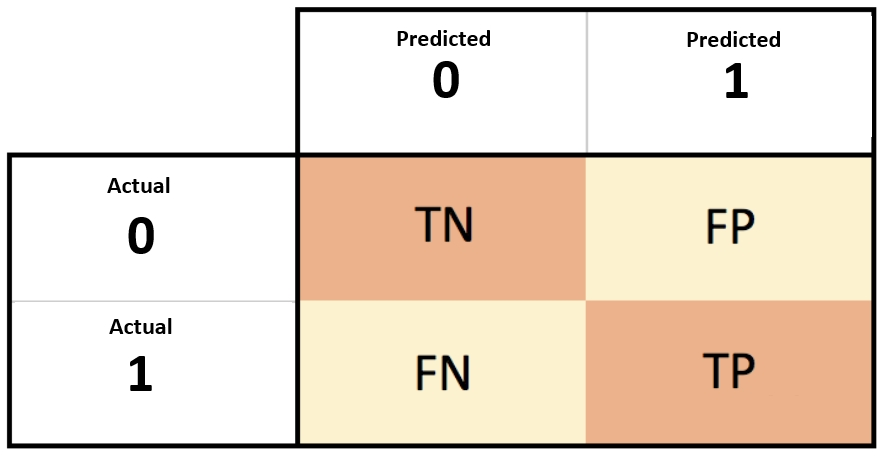

In [59]:
y_test.value_counts()

0    230
1     32
Name: Type, dtype: int64

What are your thoughts on the performance of the model? Write your conclusions below.

In [ ]:
# Your conclusions here:
#vamos con el supuesto de que 0 es NO maliciosa (benigna) y 1 es maliciosa 
#El modelo es bastante bueno porque el accuracy_score nos dio 0.935
#De los 230 valores 0 (benignos), 226 fueron predecidos correctamente y 4 fueron predecidos erroneos (Eran benignos y dijeron que eran malignos)
#De los 32 valores 1 (malignos), 13 fueron predecidos correctamente y 19 fueron predecidos erroneos (Eran malignos y dijeron que eran benignos)


#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [61]:
# Your code here:

from sklearn.neighbors import KNeighborsClassifier


To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [62]:
# Your code here:

kn_model = KNeighborsClassifier(n_neighbors = 3)
kn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [63]:
y_pred_kn = kn_model.predict(X_test)
accuracy_score(y_test, y_pred_kn)

0.9389312977099237

In [65]:
y_test.value_counts()

0    230
1     32
Name: Type, dtype: int64

In [64]:
pd.DataFrame(confusion_matrix(y_test, y_pred_kn), index=['Benigno (0)', 'Maligno (1)'], columns=['Positivo', 'Negativo'])

,Positivo,Negativo
Benigno (0),224,6
Maligno (1),10,22


#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [66]:
# Your code here:
kn_model = KNeighborsClassifier(n_neighbors = 5)
kn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [67]:
y_pred_kn = kn_model.predict(X_test)
accuracy_score(y_test, y_pred_kn)

0.950381679389313

In [68]:
y_test.value_counts()

0    230
1     32
Name: Type, dtype: int64

In [69]:
pd.DataFrame(confusion_matrix(y_test, y_pred_kn), index=['Benigno (0)', 'Maligno (1)'], columns=['Positivo', 'Negativo'])

,Positivo,Negativo
Benigno (0),227,3
Maligno (1),10,22


Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [70]:
# Your conclusions here:

#vamos con el supuesto de que 0 es NO maliciosa (benigna) y 1 es maliciosa 
#El modelo con n_neighbours = 5 es mejor, con un accuracy de 0.95
#De los 230 valores 0 (benignos), 227 fueron predecidos correctamente y 3 fueron predecidos erroneos (Eran benignos y dijeron que eran malignos)
#De los 32 valores 1 (malignos), 10 fueron predecidos correctamente y 22 fueron predecidos erroneos (Eran malignos y dijeron que eran benignos)

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [ ]:
# Your code here